Utility notebook to skim candidates

# Import

In [1]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import itertools
import json
from multiprocessing import Pool

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import col_dic, plot_gridVarQ2
from progressBar import ProgressBar
from categoriesDef import categories
# from B02DstMu_selection_v0 import candidateSelection_stringList as candidateSelection_stringList_v0
# from B02DstMu_selection_v0 import candidateSelection_nameList as candidateSelection_nameList_v0
from B02DstMu_selection import candidateSelection_stringList
from B02DstMu_selection import candidateSelection_nameList

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = "     Simulation Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Inputs

In [3]:
loc = '/storage/user/ocerri/BPhysics/data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/skimmed/'
file_loc = {
'old': loc+'None_skipall.root',
'bare': loc+'None_skipall_bare.root',
'corr': loc+'None_skipall_corr.root',
}

# Analyze selection efficiencies

In [4]:
T = {}
for n, fp in file_loc.iteritems():
    t = rt.TChain('Tevts')
    t.Add(fp)
    T[n] = t

old
[#################]  100% - Tot. time: 3.1 s
bare
[#################]  100% - Tot. time: 3.2 s
corr
[#################]  100% - Tot. time: 3.2 s


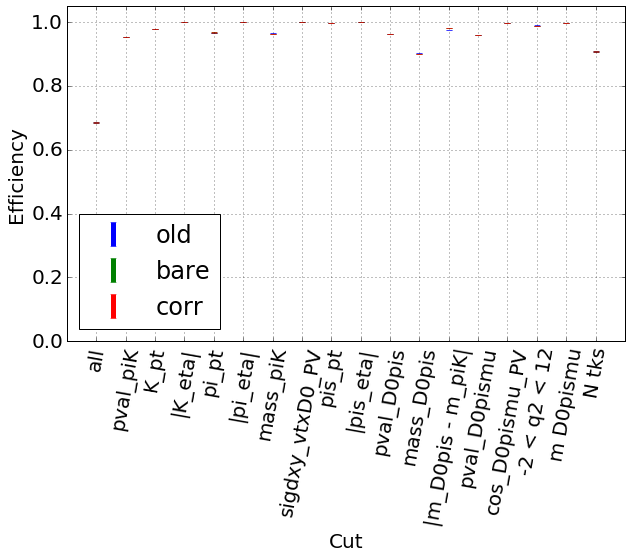

In [6]:
allCuts = ' && '.join(candidateSelection_stringList)
eff = {}
for n in T.keys():
    print n
    t = T[n]
    eff[n] = np.zeros((len(candidateSelection_stringList)+1,2))
    Ntot = float(t.GetEntries())
    Nsel = t.GetEntries(allCuts)
    eff[n][0] = getEff(Nsel, Ntot)
    pb = ProgressBar(maxEntry=len(candidateSelection_stringList))
    for ic, c in enumerate(candidateSelection_stringList):
        pb.show(ic)
        eff[n][ic+1] = getEff(t.GetEntries(c), Ntot)

for n in T.keys():
    y = np.array(eff[n])
    x = np.arange(y.shape[0])
    plt.errorbar(x, y[:, 0], y[:,1], lw=0, elinewidth=5, label=n)

plt.rcParams.update({'font.size': 20})
plt.xlabel('Cut')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.xticks(range(len(candidateSelection_nameList)+1), ['all']+candidateSelection_nameList, rotation=80)
plt.ylim(0,1.05)
plt.xlim(-1, len(candidateSelection_nameList)+1)
plt.grid()
plt.gcf().set_size_inches(10, 6)

old
old 23.41 +/- 0.03 %
old 17.87 +/- 0.03 %
old 19.24 +/- 0.03 %
bare
bare 23.42 +/- 0.03 %
bare 17.88 +/- 0.03 %
bare 19.26 +/- 0.03 %
corr
corr 23.42 +/- 0.03 %
corr 17.88 +/- 0.03 %
corr 19.26 +/- 0.03 %


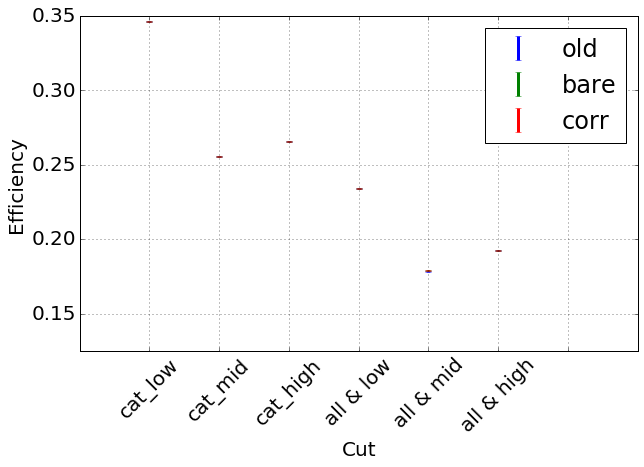

In [7]:
allCuts = ' && '.join(candidateSelection_stringList)
cat = ['cat_low', 'cat_mid', 'cat_high']
eff = {}
for n, t in T.iteritems():
    print n
    eff[n] = np.zeros((2*len(cat), 2))
    Ntot = float(t.GetEntries())
    Nsel = t.GetEntries(allCuts)
    eff[n][0] = getEff(Nsel, Ntot)
    for ic, c in enumerate(cat):
        eff[n][ic] = getEff(t.GetEntries(c), Ntot)
    for ic, c in enumerate(cat):
        eff[n][ic+len(cat)] = getEff(t.GetEntries(c + ' && ' + allCuts), Ntot)
        print n, '{:.2f} +/- {:.2f} %'.format(*(100*eff[n][ic+len(cat)]))

for n in T.keys():
    y = np.array(eff[n])
    x = np.arange(y.shape[0])
    plt.errorbar(x, y[:, 0], y[:,1], lw=0, elinewidth=3, label=n)

plt.rcParams.update({'font.size': 20})
plt.xlabel('Cut')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.xticks(range(2*len(cat)+1), cat+['all & '+c.replace('cat_', '') for c in cat], rotation=45)
plt.ylim(0.7*np.min([np.min(e[:,0]) for e in eff.values()]), plt.ylim()[1])
plt.xlim(-1,plt.xlim()[1]+1)
# plt.yscale('log')
plt.grid()
plt.gcf().set_size_inches(10, 6)